# Sparseloop Tutorial - 01 - Dot Product

This notebook contains a series of examples of a **dot product** computation, i.e., a reduction of the element-wise products of all the elements of the inputs. The **fibertree** emulator is used to illustrate the impact of a set of optimizations to exploit sparsity. The basic computation is represented by the Einsum:

$$ Z_m = A_k \times B_k $$

Note that while the output is nominally a scalar, for consistency with the **Timeloop** tool the output implemented as a 1-D tensor. However, that tensor contains only a single element.

First, include some libraries

In [7]:
# Run boilerplate code to set up environment

%run ./prelude.py --style=tree --animation=movie

interactive(children=(Dropdown(description='style', options=('tree', 'uncompressed', 'tree+uncompressed'), val…

Button(description='Run all cells below', style=ButtonStyle())

## Configure two rank-1 input tensors

The following cell sets up the control sliders to specify the attributes of the `A` and `B` input tensors. Those attributes include their **shape**, which specifies the allowable range of **coordinates** of elements of the tensor and their **density**.

The rank names use the following convention:

- K - contracted dimension shared by `A` and `B`
- M - dummy rank for output `Z`

In [8]:
#
# Set default problem instance attributes (i.e., the shape of the tensors)
#
K = 10
M = 1

#
# Create controls to configure the `A` and `B` tensors
#
tm = TensorMaker("sparseloop-dot-product")

tm.addTensor("A", rank_ids=["K"], shape=[K], density=0.4, color="blue")
tm.addTensor("B", rank_ids=["K"], shape=[K], density=1.0, color="green")

tm.displayControls()


interactive(children=(Label(value='Tensor Creation Controls', description='Title'), Label(value='Tensor A', de…

## Create and display the tensors

Create the `A` and `B` tensors based on the current settings of the configuration sliders above and display the resulting tensors. These tensors are represented in the **fibertree** tensor abstraction, where for sparse fibers only the **elements** (**coordinate**/**payload** tuples) in a fiber with **non-empty** (non-zero) payloads need be shown.  

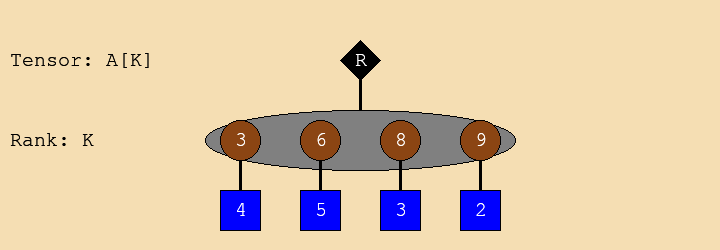

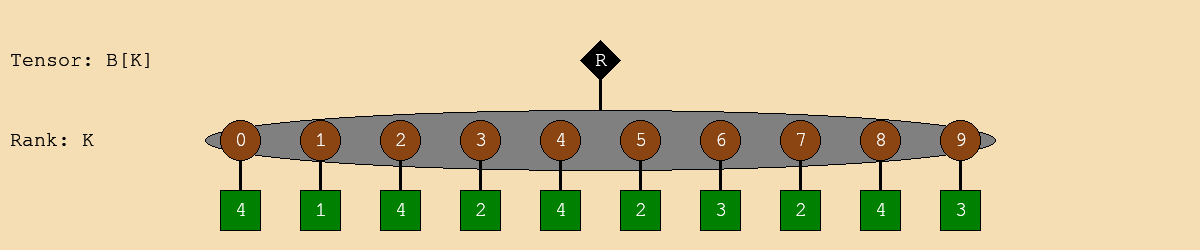

In [9]:
A_K = tm.makeTensor("A")
B_K = tm.makeTensor("B")

displayTensor(A_K)
displayTensor(B_K)


# Dot product - A, B uncompressed

The following code sequence corresponds to an implementation of dot product where the hardware must read every **coordinate** of each input tensor and reduces the element-wise products of those values into the output irrespective of whether any **payload** value is zero. This corresponds to the totally unoptimized case.

Notes:

- The code below uses the `Fiber.getPayload()` method to obtain a **payload** value by **coordinate**. For `A` and `B` in an **uncompressed** format this is a cheap direct access because the **coordinate** equals the **position** of the value, but the operation could be much more expensive for other formats.

- To force a useful visualization of the traversal of the `A` tensor it's **empty** coordinates are filled with zeros using the `uncompressTensor()` method.

- The code below assumes that the output tensor `Z` is in an uncompressed format. Again this is facilitated with the `uncompressTensor()` method and allows updates to be performed with direct indexing into the output tensor by **coordinate** (again because for uncompressed formats the **coordinate** and **position** are equal).

Observations:

- The computation takes `K` cycles irrespective of the sparsity of the the input tensors.

- The hardware reads a value from both tensors irrespective of whether a **payload** value in `A` is zero.

Problem instance:
K: 10
M: 1

Input tensor A


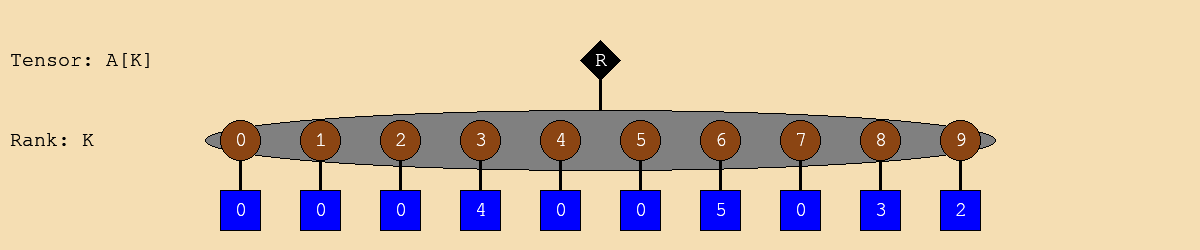

Input tensor B


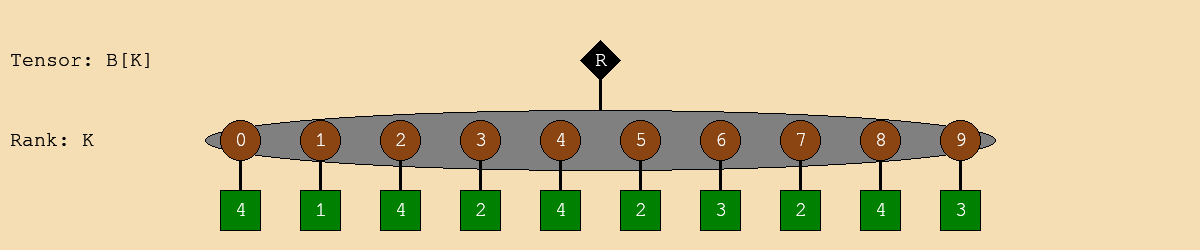

Output tensor Z (intial)


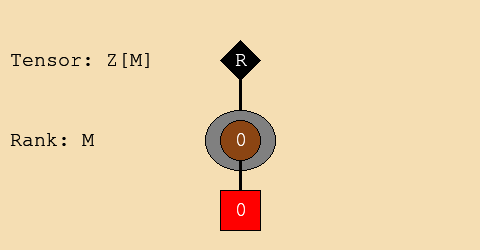

Output tensor Z (final)


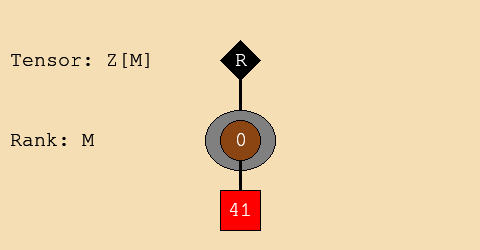

In [10]:
#
# Create the input/output tensors
#
K = getShape(tm, "K")
M = 1

A_K = tm.makeTensor("A")
B_K = tm.makeTensor("B")
Z_M = Tensor(name="Z", rank_ids=["M"], shape=[M])

uncompressTensor(A_K)
uncompressTensor(Z_M)

#
# Display the input tensors
#
print("Problem instance:")
print(f"K: {K}")
print(f"M: {M}")
print("")

print("Input tensor A")
displayTensor(A_K)
print("Input tensor B")
displayTensor(B_K)
print("Output tensor Z (intial)")
displayTensor(Z_M)

#
# Get the root fibers of each tensor
#
a_k = A_K.getRoot()
b_k = B_K.getRoot()
z_m = Z_M.getRoot()

#
# Animation bookkeeping
#
canvas = createCanvas(A_K, B_K, Z_M)

#
# Traverse all `M` coordinates of the output tensor
#
for m in range(M):

    #
    # Traverse all `K` coordinates of the input tensors
    #
    for k in range(K):
        #
        # Get the values of `A` and `B` at coordinate `k`
        #
        a_val = a_k.getPayload(k)
        b_val = b_k.getPayload(k)
    
        #
        # Do the dot product multiplication and reduction
        #
        z_m[m] += a_val * b_val
    
        #
        # Animation bookkeeping
        #
        canvas.addActivity([(k,)], [(k,)], [(m,)],
                           spacetime=(0, k))
    
    
#
# Display results
#
print("Output tensor Z (final)")
displayTensor(Z_M)

displayCanvas(canvas)

# Dot Product - Gating Unneeded Reads

The following code sequence corresponds to an implementation of dot product where the hardware must read every **coordinate** of the input tensor `A` but then **gates** the read of `B` and computation when the **payload** value of an element of tensor `A` is zero. This corresponds to the case where `B` is gated on `A`.

Notes:

- The code below again uses the `Fiber.getPayload()` method to obtain a **payload** value by **coordinate** for both the `A` and `B` tensors. 

- The cost of the reference to `A` may vary based on whether the specific format needs to do an access for **coordinates** with zero values.

- As in the case above, the code in this cell assumes that the output tensor `Z` is in an uncompressed format.

Observations:

- The computation takes `K` cycles irrespective of the sparsity of the the input tensors

- The hardware saves reads of data and computation when the **payload** value of `A` is zero.

Problem instance:
K: 10
M: 1

Input A


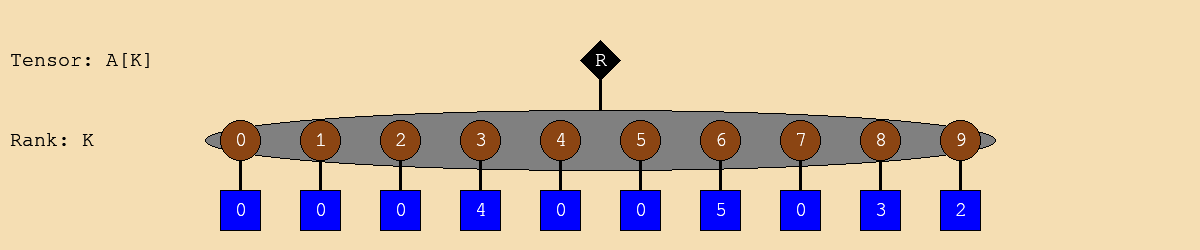

Input B


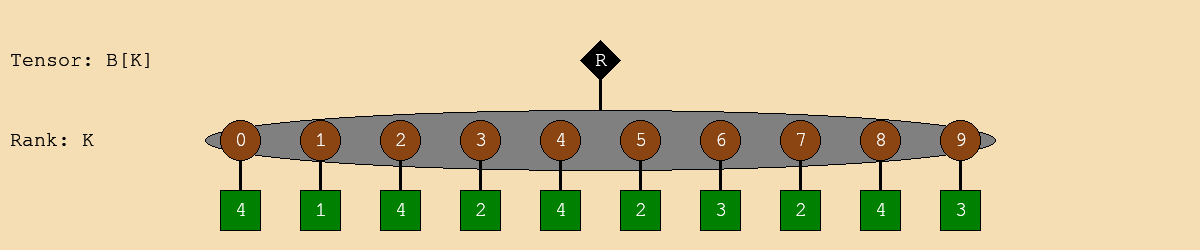

Output Z (initial)


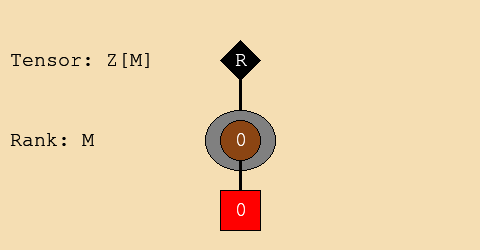

Output tensor Z (final)


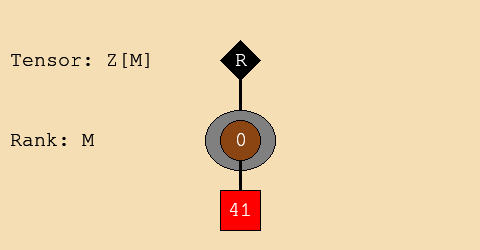

In [11]:
#
# Create the input/output tensors
#
K = getShape(tm, "K")
M = 1

A_K = tm.makeTensor("A")
B_K = tm.makeTensor("B")
Z_M = Tensor(name="Z", rank_ids=["M"], shape=[M])

uncompressTensor(A_K)
uncompressTensor(Z_M)

#
# Display the input tensors
#
print("Problem instance:")
print(f"K: {K}")
print(f"M: {M}")
print("")

print("Input A")
displayTensor(A_K)
print("Input B")
displayTensor(B_K)
print("Output Z (initial)")
displayTensor(Z_M)

#
# Get the root fibers of each tensor
#
a_k = A_K.getRoot()
b_k = B_K.getRoot()
z_m = Z_M.getRoot()

#
# Animation bookkeeping
#
canvas = createCanvas(A_K, B_K, Z_M)

#
# Traverse the single element of the output shape
#
for m in range(M):
    #
    # Traverse all `K` coordinates of the input tensor `A`
    #
    for k in range(K):
        #
        # Get the value of `A` at coordinate `k`
        #
        a_val = a_k.getPayload(k)
    
        #
        # Gate the access to the value of `B`
        # and computation based on the value of `A`
        #
        if a_val != 0:
            b_val = b_k.getPayload(k)

            z_m[m] += a_val * b_val

        #
        # Animation bookkeeping
        #
        if a_val == 0:
            B_activity = []
            Z_activity = []
        else:
            B_activity = [(k,)]
            Z_activity = [(m,)]
        
        canvas.addActivity([(k,)], B_activity, Z_activity,
                           spacetime=(0, k))
    

#
# Display results
#
print("Output tensor Z (final)")
displayTensor(Z_M)

displayCanvas(canvas)

# Dot Product - Skipping "empty" coordinates in A

The following code sequence corresponds to an implementation of dot product where the hardware can traverse just the **non-empty** elements of the input tensor `A` and then only accesses the elements of `B` for the **coordinates** of those **non-empty** elements of `A`. This corresponds to the case where there is **skipping** of elements of `A`.

Notes:

- The code below uses the default `Fiber` iterator to obtain the **coordinates** and **payloads** of the **non-empty** elements of tensor `A`. 

- The cost of the reference to `B` using `Fiber.getPayload()` will vary based on the cost of finding a **payload** by **coordinates** for the specific format used for `B`.

- As in the case above, the code in this cell assumes that the output tensor `Z` is in an uncompressed format.

Observations:

- The computation takes a number of cycles (and does reads and computes) proportional to the number of **non-empty** elements in `A`, i.e., `A`'s **occupancy**.


Problem instance:
K: 10
M: 1

Input A


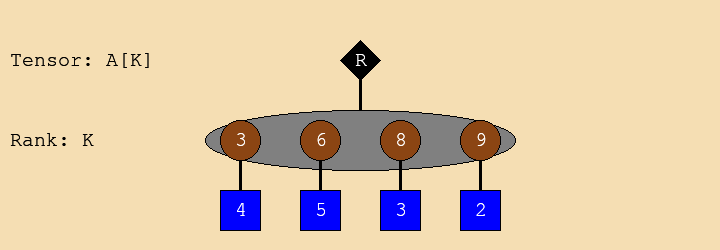

Input B


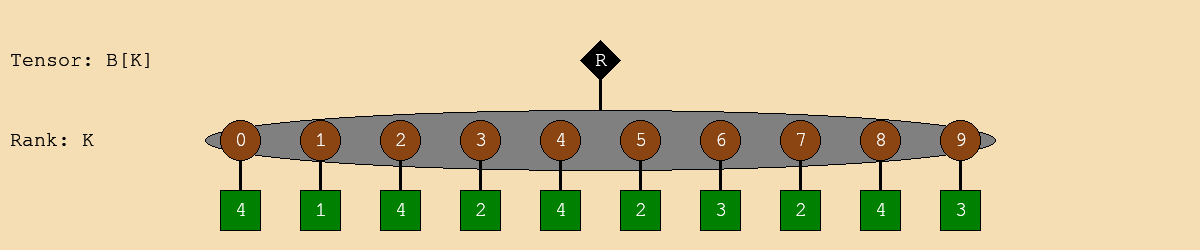

Output Z (initial)


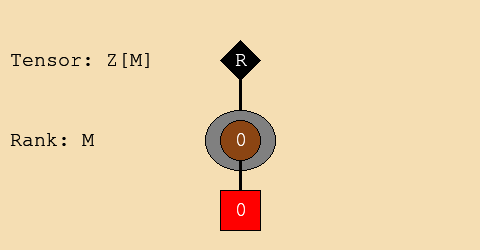

Output tensor Z (final)


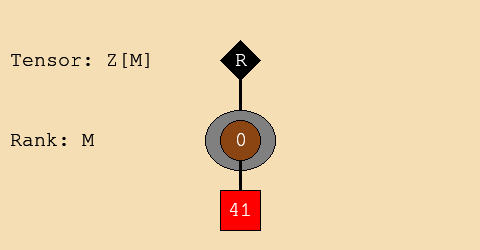

In [12]:
#
# Create the input/output tensors
#
K = getShape(tm, "K")
M = 1

A_K = tm.makeTensor("A")
B_K = tm.makeTensor("B")
Z_M = Tensor(name="Z", rank_ids=["M"], shape=[M])

uncompressTensor(Z_M)

#
# Display the input tensors
#
print("Problem instance:")
print(f"K: {K}")
print(f"M: {M}")
print("")

print("Input A")
displayTensor(A_K)
print("Input B")
displayTensor(B_K)
print("Output Z (initial)")
displayTensor(Z_M)

#
# Get the root fibers of each tensor
#
a_k = A_K.getRoot()
b_k = B_K.getRoot()
z_m = Z_M.getRoot()


#
# Animation bookkeeping
#
canvas = createCanvas(A_K, B_K, Z_M)

#
# Traverse the single element of the output shape
#
for m in range(M):
    #
    # Traverse non-empty elements of the tensor `A`
    #
    for k, a_val in a_k:
        #
        # Get value of `B` at non-zero coordinates of `A`
        # and then do compute
        #
        b_val = b_k.getPayload(k)

        z_m[m] += a_val * b_val

        #
        # Animation bookkeeping
        #
        canvas.addActivity([(k,)], [(k,)], [(m,)],
                           spacetime=(0, k))

#
# Display results
#
print("Output tensor Z (final)")
displayTensor(Z_M)

displayCanvas(canvas)

## Testing area

For running alternative algorithms